<a href="https://colab.research.google.com/github/SLVmain/PyTorch_start/blob/Les_04/HW_04_CNN_cifar100_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Домашнее задание. Урок 4. CNN Свертки
Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) сверточной сетью (самописной)
Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50
Обучение классификатора картинок на примере CIFAR-100 (датасет можно изменить) через дообучение ImageNet Resnet-50 с аугментацией (самописной, с использованием Pytorch встроенных методов)

In [1]:
import numpy as np
import torch

from torch import nn
import torchvision
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
import shutil

path = "/content/data"
shutil.rmtree(path)

In [3]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(degrees=(0, 8)),
                                    transforms.RandomAdjustSharpness(sharpness_factor=2),
                                    transforms.RandomCrop(32, padding=4, padding_mode="reflect"), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(*stats)])

trans_actions_test = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(*stats)])


train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, trans_actions_test)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=3)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/


In [32]:
for image,label in train_loader:
    print("Image shape: ",image.shape)
    print("Image tensor: ", image)
    print("Label: ", label)
    break

for image,label in valid_loader:
    print("Image shape: ",image.shape)
    print("Image tensor: ", image)
    print("Label: ", label)
    break

Image shape:  torch.Size([128, 3, 32, 32])
Image tensor:  tensor([[[[ 0.6157,  0.7020,  0.6706,  ..., -0.7020, -0.6000, -0.5216],
          [ 0.6706,  0.8431,  0.7647,  ..., -0.6941, -0.7333, -0.5686],
          [ 0.8667,  0.9216,  0.8588,  ..., -0.4275, -0.5765, -0.4039],
          ...,
          [ 0.6314,  0.3882,  0.0196,  ..., -0.1765, -1.0000, -1.0000],
          [ 0.7333,  0.4118,  0.0745,  ..., -0.4275, -0.3098, -0.2706],
          [ 0.7882,  0.4667,  0.0196,  ..., -0.5686, -0.4196, -0.3882]],

         [[ 0.1294,  0.0039, -0.1216,  ..., -0.5529, -0.4196, -0.3255],
          [ 0.0118,  0.3176,  0.1216,  ..., -0.5765, -0.6392, -0.3961],
          [ 0.3882,  0.5843,  0.3412,  ..., -0.2235, -0.3961, -0.1294],
          ...,
          [ 0.1765, -0.1922, -0.6863,  ...,  0.2941, -1.0000, -1.0000],
          [ 0.4275, -0.0118, -0.6000,  ..., -0.0980,  0.0431,  0.0824],
          [ 0.4667,  0.0510, -0.5529,  ..., -0.3098, -0.1059, -0.0980]],

         [[ 0.3725,  0.2863,  0.2235,  ..., 

In [4]:
classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
                    'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
                    'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
                    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
                    'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
                    'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
                    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
                    'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
                    'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

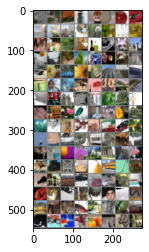

snail shrew maple_tree bottle bottle


In [34]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(5)))

In [35]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 200)
        self.fc2 = torch.nn.Linear(200, 60)
        self.out = torch.nn.Linear(60, 100)
        
        
    def forward(self, x):
        #x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net()
print(net)

Net(
  (dp_three): Dropout(p=0.2, inplace=False)
  (dp_four): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=100, bias=True)
)


In [36]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [29]:
for epoch in tqdm(range(10)):  
    net.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    net.eval()
    loss_accumed = 0
    for X, y in valid_loader:
        output = net(X)
        loss = criterion(output, y)
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

 10%|█         | 1/10 [00:41<06:15, 41.77s/it]

Epoch 0 valid_loss 84.167236328125


 20%|██        | 2/10 [01:23<05:32, 41.53s/it]

Epoch 1 valid_loss 77.42247009277344


 30%|███       | 3/10 [02:05<04:52, 41.84s/it]

Epoch 2 valid_loss 73.78138732910156


 40%|████      | 4/10 [02:47<04:11, 41.88s/it]

Epoch 3 valid_loss 71.48516082763672


 50%|█████     | 5/10 [03:29<03:29, 41.90s/it]

Epoch 4 valid_loss 70.37422943115234


 60%|██████    | 6/10 [04:11<02:47, 41.96s/it]

Epoch 5 valid_loss 68.70604705810547


 70%|███████   | 7/10 [04:53<02:05, 41.88s/it]

Epoch 6 valid_loss 67.22708892822266


 80%|████████  | 8/10 [05:34<01:23, 41.89s/it]

Epoch 7 valid_loss 66.23456573486328


 90%|█████████ | 9/10 [06:16<00:41, 41.92s/it]

Epoch 8 valid_loss 64.93138885498047


100%|██████████| 10/10 [06:58<00:00, 41.88s/it]

Epoch 9 valid_loss 64.1535415649414
Training is finished!


# используем претрейнед сеть

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
from torchvision import models
import torchvision.transforms as T

resnet50 = models.resnet50(pretrained=True)
resnet50.to(device)

#resnet18 = models.resnet18(pretrained=True)
#alexnet = models.alexnet(pretrained=True)
#vgg16 = models.vgg16(pretrained=True)
#inception = models.inception_v3(pretrained=True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
print(resnet50)

In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [8]:
num_ftrs = resnet50.fc.in_features
num_ftrs

2048

In [9]:
set_parameter_requires_grad(resnet50, True)

In [10]:
num_classes = 100
resnet50.fc = nn.Linear(num_ftrs, num_classes)

In [11]:
# Необходимые трансформации размер изображений на входе должен быть 224 на 224, 3 канала
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [12]:
trans_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    normalize])


valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       normalize])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=3)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [13]:
for image,label in train_loader:
    print("Image shape: ",image.shape)
    #print("Image tensor: ", image)
    #print("Label: ", label)
    break

for image,label in valid_loader:
    print("Image shape: ",image.shape)
    #print("Image tensor: ", image)
    #print("Label: ", label)
    break

Image shape:  torch.Size([128, 3, 224, 224])
Image shape:  torch.Size([128, 3, 224, 224])


In [14]:
params_to_update = []
for name,param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [15]:
params_to_update

[Parameter containing:
 tensor([[-2.2161e-03,  2.2581e-03, -9.1088e-03,  ...,  9.8173e-05,
          -6.7349e-03,  7.4602e-03],
         [ 8.1576e-03, -1.6465e-02,  6.1960e-03,  ..., -1.7486e-03,
          -1.5036e-02,  9.7467e-03],
         [-7.6686e-03,  4.2970e-04, -2.2077e-02,  ...,  1.4333e-02,
          -1.2911e-02,  1.1404e-02],
         ...,
         [ 7.2573e-03,  2.3407e-03,  2.0483e-03,  ...,  1.1416e-02,
           1.4260e-02,  1.0350e-02],
         [-8.9097e-03,  2.1145e-02,  5.7081e-03,  ..., -1.7686e-02,
          -1.4394e-02, -1.5570e-02],
         [ 1.9799e-02, -5.7480e-03,  1.8418e-03,  ..., -1.4421e-02,
           3.5792e-03,  2.0736e-02]], requires_grad=True),
 Parameter containing:
 tensor([ 0.0154, -0.0083,  0.0161, -0.0152, -0.0005,  0.0170,  0.0098,  0.0173,
         -0.0120,  0.0171,  0.0049,  0.0034,  0.0182,  0.0193, -0.0133,  0.0013,
         -0.0213,  0.0101, -0.0173,  0.0005, -0.0072,  0.0192,  0.0087,  0.0087,
         -0.0156, -0.0022,  0.0158, -0.0034, 

In [19]:
for epoch in tqdm(range(10)):  
    resnet50.train().to(device)
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    resnet50.eval().to(device)
    loss_accumed = 0
    for X, y in valid_loader:
        X, y = X.to(device), y.to(device)
        output = resnet50(X)
        loss = criterion(output, y)
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

 10%|█         | 1/10 [01:24<12:44, 84.94s/it]

Epoch 0 valid_loss 36.54513168334961


 20%|██        | 2/10 [02:49<11:19, 84.92s/it]

Epoch 1 valid_loss 32.194969177246094


 30%|███       | 3/10 [04:14<09:54, 84.95s/it]

Epoch 2 valid_loss 32.453521728515625


 40%|████      | 4/10 [05:39<08:29, 84.96s/it]

Epoch 3 valid_loss 30.42387580871582


 50%|█████     | 5/10 [07:04<07:04, 84.99s/it]

Epoch 4 valid_loss 30.89453125


 60%|██████    | 6/10 [08:30<05:40, 85.07s/it]

Epoch 5 valid_loss 30.633724212646484


 70%|███████   | 7/10 [09:55<04:15, 85.06s/it]

Epoch 6 valid_loss 29.579675674438477


 80%|████████  | 8/10 [11:20<02:50, 85.06s/it]

Epoch 7 valid_loss 30.92918586730957


 90%|█████████ | 9/10 [12:44<01:24, 84.95s/it]

Epoch 8 valid_loss 30.397432327270508


100%|██████████| 10/10 [14:09<00:00, 84.94s/it]

Epoch 9 valid_loss 29.293893814086914
Training is finished!


Михаил, еще вопрос к Вам: в transforms документации нашла AutoAugmentPolicy
policies = [T.AutoAugmentPolicy.CIFAR10, T.AutoAugmentPolicy.IMAGENET, T.AutoAugmentPolicy.SVHN]

Можете пояснить, как пользоваться ими? пыталась запихнуть к трансформерам в compose, не получилось

https://pytorch.org/vision/main/generated/torchvision.transforms.AutoAugmentPolicy.html#torchvision.transforms.AutoAugmentPolicy

In [37]:
trans_actions = transforms.Compose([T.AutoAugmentPolicy.CIFAR10,
                                    transforms.Resize(224),
                                    transforms.ToTensor(),
                                    normalize])


valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       normalize])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=3)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

In [38]:
for epoch in tqdm(range(10)):  
    resnet50.train().to(device)
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    resnet50.eval().to(device)
    loss_accumed = 0
    for X, y in valid_loader:
        X, y = X.to(device), y.to(device)
        output = resnet50(X)
        loss = criterion(output, y)
        loss_accumed += loss
    print("Epoch {} valid_loss {}".format(epoch, loss_accumed))

print('Training is finished!')

  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: ignored